In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm



In [2]:
train_dataset_path = 'C:\\Users\\PC\\Desktop\\lisnen_data\\validation_data\\train'
val_dataset_path = 'C:\\Users\\PC\\Desktop\\lisnen_data\\validation_data\\val'


In [3]:

# Define transformations for the training and validation sets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # Ensures the data is converted to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Ensures the data is converted to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dataset_path, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [4]:
# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer to output 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

c:\Users\PC\anaconda3\envs\crnn\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\anaconda3\envs\crnn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
# applying spatial attention
import torch
import torch.nn as nn
from torchvision import models

# Define the Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // 8, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention = self.conv1(x)
        attention = self.conv2(attention)
        attention = self.sigmoid(attention)
        return x * attention

# Integrate the Spatial Attention Module into ResNet-50
class ResNet50WithAttention(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50WithAttention, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.attention = SpatialAttention(in_channels=2048)  # 2048 channels after layer4 in ResNet-50
        self.fc = nn.Linear(2048, num_classes)  # Adjust the final fully connected layer

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.attention(x)  # Apply the attention mechanism here

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the model
num_classes = 4  # Number of classes for your audio event classification
model = ResNet50WithAttention(num_classes=num_classes)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


c:\Users\PC\anaconda3\envs\crnn\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\anaconda3\envs\crnn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# Training function with progress bar and metric tracking
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    
    train_precision_history = []
    val_precision_history = []
    train_recall_history = []
    val_recall_history = []
    train_f1_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()  # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f'{phase} {epoch}/{num_epochs - 1}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            epoch_precision = precision_score(all_labels, all_preds, average='weighted')
            epoch_recall = recall_score(all_labels, all_preds, average='weighted')
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1 Score: {epoch_f1:.4f}')

            # Save the metrics
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                train_precision_history.append(epoch_precision)
                train_recall_history.append(epoch_recall)
                train_f1_history.append(epoch_f1)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                val_precision_history.append(epoch_precision)
                val_recall_history.append(epoch_recall)
                val_f1_history.append(epoch_f1)

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_precision_history, val_precision_history, train_recall_history, val_recall_history, train_f1_history, val_f1_history

# Train the model
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_precision_history, val_precision_history, train_recall_history, val_recall_history, train_f1_history, val_f1_history = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=25)


Epoch 0/24
----------


train 0/24: 100%|██████████| 47/47 [00:19<00:00,  2.41it/s]


train Loss: 0.5702 Acc: 0.8032 Precision: 0.7997 Recall: 0.8032 F1 Score: 0.8011


val 0/24: 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]


val Loss: 0.5403 Acc: 0.8172 Precision: 0.8547 Recall: 0.8172 F1 Score: 0.8153
Epoch 1/24
----------


train 1/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.3311 Acc: 0.8863 Precision: 0.8858 Recall: 0.8863 F1 Score: 0.8860


val 1/24: 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]


val Loss: 0.2604 Acc: 0.9194 Precision: 0.9236 Recall: 0.9194 F1 Score: 0.9205
Epoch 2/24
----------


train 2/24: 100%|██████████| 47/47 [00:18<00:00,  2.52it/s]


train Loss: 0.2343 Acc: 0.9149 Precision: 0.9151 Recall: 0.9149 F1 Score: 0.9150


val 2/24: 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]


val Loss: 0.6339 Acc: 0.7527 Precision: 0.8214 Recall: 0.7527 F1 Score: 0.7403
Epoch 3/24
----------


train 3/24: 100%|██████████| 47/47 [00:18<00:00,  2.50it/s]


train Loss: 0.2231 Acc: 0.9102 Precision: 0.9097 Recall: 0.9102 F1 Score: 0.9099


val 3/24: 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]


val Loss: 0.2614 Acc: 0.8978 Precision: 0.9017 Recall: 0.8978 F1 Score: 0.8987
Epoch 4/24
----------


train 4/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.1458 Acc: 0.9441 Precision: 0.9443 Recall: 0.9441 F1 Score: 0.9442


val 4/24: 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]


val Loss: 0.2414 Acc: 0.9409 Precision: 0.9460 Recall: 0.9409 F1 Score: 0.9399
Epoch 5/24
----------


train 5/24: 100%|██████████| 47/47 [00:18<00:00,  2.50it/s]


train Loss: 0.1672 Acc: 0.9475 Precision: 0.9478 Recall: 0.9475 F1 Score: 0.9475


val 5/24: 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]


val Loss: 0.1415 Acc: 0.9462 Precision: 0.9479 Recall: 0.9462 F1 Score: 0.9468
Epoch 6/24
----------


train 6/24: 100%|██████████| 47/47 [00:18<00:00,  2.53it/s]


train Loss: 0.1152 Acc: 0.9601 Precision: 0.9605 Recall: 0.9601 F1 Score: 0.9603


val 6/24: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


val Loss: 0.4869 Acc: 0.8441 Precision: 0.8784 Recall: 0.8441 F1 Score: 0.8338
Epoch 7/24
----------


train 7/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.1040 Acc: 0.9628 Precision: 0.9627 Recall: 0.9628 F1 Score: 0.9627


val 7/24: 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]


val Loss: 0.1510 Acc: 0.9624 Precision: 0.9658 Recall: 0.9624 F1 Score: 0.9622
Epoch 8/24
----------


train 8/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.0762 Acc: 0.9774 Precision: 0.9774 Recall: 0.9774 F1 Score: 0.9774


val 8/24: 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]


val Loss: 0.1054 Acc: 0.9516 Precision: 0.9518 Recall: 0.9516 F1 Score: 0.9516
Epoch 9/24
----------


train 9/24: 100%|██████████| 47/47 [00:18<00:00,  2.52it/s]


train Loss: 0.0408 Acc: 0.9900 Precision: 0.9901 Recall: 0.9900 F1 Score: 0.9900


val 9/24: 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]


val Loss: 0.1336 Acc: 0.9516 Precision: 0.9536 Recall: 0.9516 F1 Score: 0.9517
Epoch 10/24
----------


train 10/24: 100%|██████████| 47/47 [00:18<00:00,  2.52it/s]


train Loss: 0.0882 Acc: 0.9707 Precision: 0.9708 Recall: 0.9707 F1 Score: 0.9708


val 10/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.3624 Acc: 0.8978 Precision: 0.9038 Recall: 0.8978 F1 Score: 0.8975
Epoch 11/24
----------


train 11/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.1126 Acc: 0.9628 Precision: 0.9628 Recall: 0.9628 F1 Score: 0.9627


val 11/24: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


val Loss: 0.1755 Acc: 0.9247 Precision: 0.9312 Recall: 0.9247 F1 Score: 0.9251
Epoch 12/24
----------


train 12/24: 100%|██████████| 47/47 [00:18<00:00,  2.52it/s]


train Loss: 0.0574 Acc: 0.9801 Precision: 0.9801 Recall: 0.9801 F1 Score: 0.9801


val 12/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.0548 Acc: 0.9785 Precision: 0.9787 Recall: 0.9785 F1 Score: 0.9784
Epoch 13/24
----------


train 13/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0669 Acc: 0.9774 Precision: 0.9774 Recall: 0.9774 F1 Score: 0.9774


val 13/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.2471 Acc: 0.9247 Precision: 0.9275 Recall: 0.9247 F1 Score: 0.9253
Epoch 14/24
----------


train 14/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0818 Acc: 0.9721 Precision: 0.9721 Recall: 0.9721 F1 Score: 0.9720


val 14/24: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


val Loss: 0.0766 Acc: 0.9624 Precision: 0.9647 Recall: 0.9624 F1 Score: 0.9629
Epoch 15/24
----------


train 15/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0907 Acc: 0.9721 Precision: 0.9722 Recall: 0.9721 F1 Score: 0.9721


val 15/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.1240 Acc: 0.9516 Precision: 0.9527 Recall: 0.9516 F1 Score: 0.9515
Epoch 16/24
----------


train 16/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0588 Acc: 0.9801 Precision: 0.9801 Recall: 0.9801 F1 Score: 0.9800


val 16/24: 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


val Loss: 0.1092 Acc: 0.9677 Precision: 0.9680 Recall: 0.9677 F1 Score: 0.9678
Epoch 17/24
----------


train 17/24: 100%|██████████| 47/47 [00:18<00:00,  2.53it/s]


train Loss: 0.0793 Acc: 0.9741 Precision: 0.9742 Recall: 0.9741 F1 Score: 0.9741


val 17/24: 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]


val Loss: 0.1194 Acc: 0.9516 Precision: 0.9535 Recall: 0.9516 F1 Score: 0.9521
Epoch 18/24
----------


train 18/24: 100%|██████████| 47/47 [00:18<00:00,  2.53it/s]


train Loss: 0.0348 Acc: 0.9880 Precision: 0.9881 Recall: 0.9880 F1 Score: 0.9880


val 18/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.0875 Acc: 0.9731 Precision: 0.9741 Recall: 0.9731 F1 Score: 0.9731
Epoch 19/24
----------


train 19/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0153 Acc: 0.9967 Precision: 0.9967 Recall: 0.9967 F1 Score: 0.9967


val 19/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.0850 Acc: 0.9731 Precision: 0.9744 Recall: 0.9731 F1 Score: 0.9731
Epoch 20/24
----------


train 20/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0255 Acc: 0.9927 Precision: 0.9927 Recall: 0.9927 F1 Score: 0.9927


val 20/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.0642 Acc: 0.9785 Precision: 0.9787 Recall: 0.9785 F1 Score: 0.9786
Epoch 21/24
----------


train 21/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.0308 Acc: 0.9887 Precision: 0.9887 Recall: 0.9887 F1 Score: 0.9887


val 21/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.0841 Acc: 0.9731 Precision: 0.9740 Recall: 0.9731 F1 Score: 0.9733
Epoch 22/24
----------


train 22/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.0274 Acc: 0.9920 Precision: 0.9920 Recall: 0.9920 F1 Score: 0.9920


val 22/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.2172 Acc: 0.9624 Precision: 0.9637 Recall: 0.9624 F1 Score: 0.9621
Epoch 23/24
----------


train 23/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0274 Acc: 0.9927 Precision: 0.9927 Recall: 0.9927 F1 Score: 0.9927


val 23/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.0963 Acc: 0.9570 Precision: 0.9578 Recall: 0.9570 F1 Score: 0.9572
Epoch 24/24
----------


train 24/24: 100%|██████████| 47/47 [00:18<00:00,  2.53it/s]


train Loss: 0.0562 Acc: 0.9787 Precision: 0.9787 Recall: 0.9787 F1 Score: 0.9787


val 24/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

val Loss: 0.1891 Acc: 0.9301 Precision: 0.9341 Recall: 0.9301 F1 Score: 0.9300


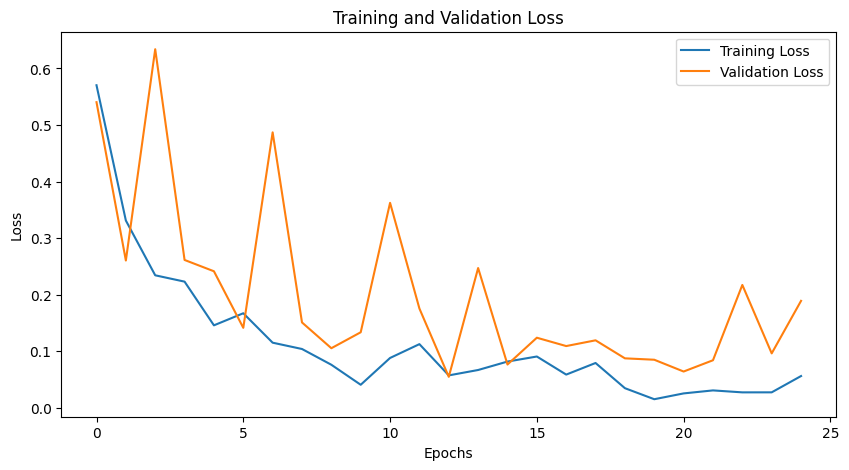

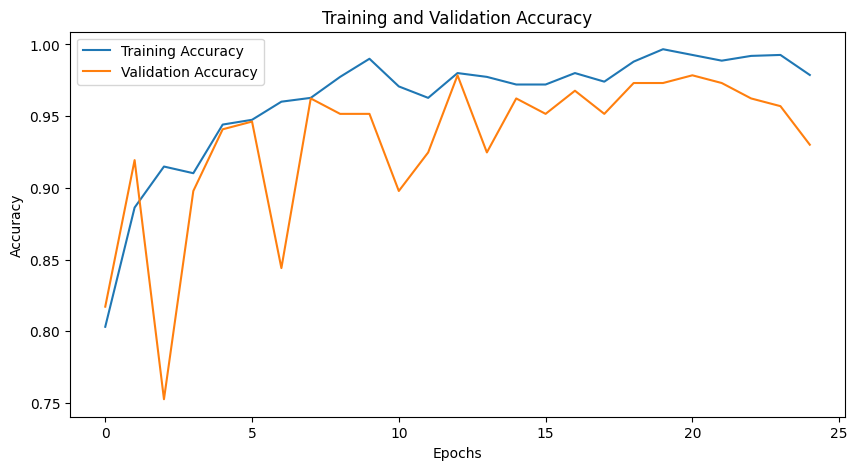

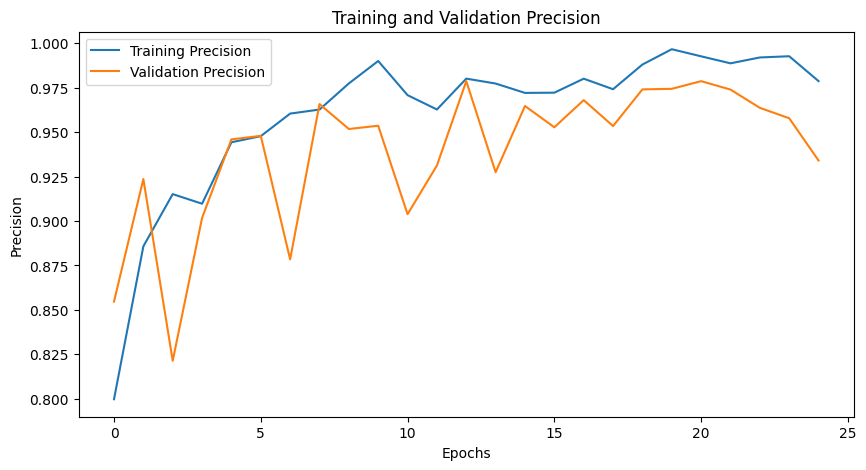

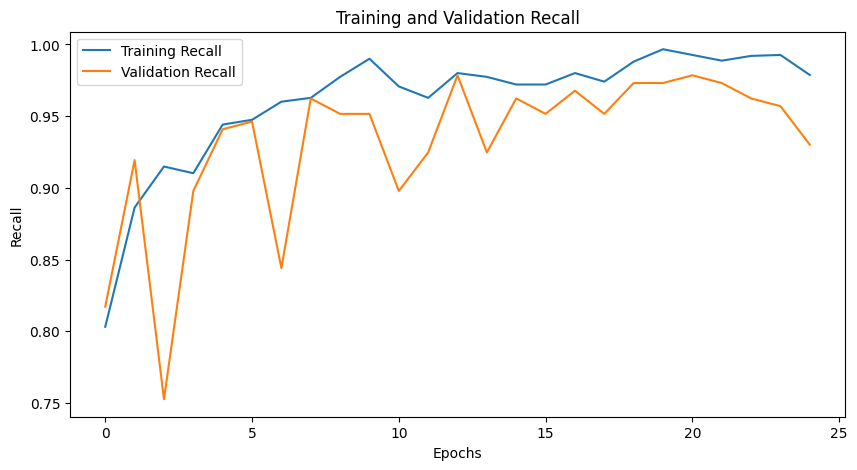

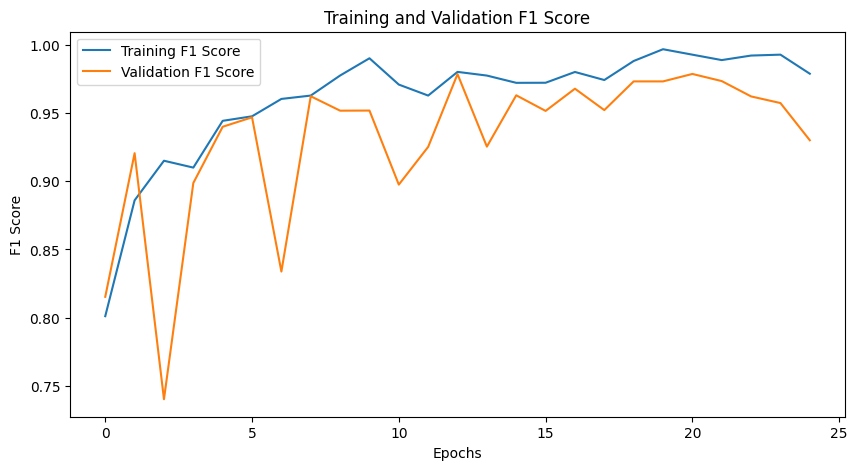

In [8]:
import numpy as np

# Convert tensor histories to numpy arrays
train_acc_history = np.array([x.cpu() for x in train_acc_history])
val_acc_history = np.array([x.cpu() for x in val_acc_history])
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation precision
plt.figure(figsize=(10, 5))
plt.plot(train_precision_history, label='Training Precision')
plt.plot(val_precision_history, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot the training and validation recall
plt.figure(figsize=(10, 5))
plt.plot(train_recall_history, label='Training Recall')
plt.plot(val_recall_history, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Plot the training and validation F1 score
plt.figure(figsize=(10, 5))
plt.plot(train_f1_history, label='Training F1 Score')
plt.plot(val_f1_history, label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


In [9]:
# Save the trained model to a specified path
save_path = 'C:\\Users\\PC\\Desktop\\lisnen_research_files\\audio_research_crnn_files\\model_weights\\resnet_50_attention.pth'
torch.save(model.state_dict(), save_path)

In [10]:
# Define the transformations for the test set
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the test dataset
test_dataset_path = 'C:\\Users\\PC\\Desktop\\lisnen_data\\validation_data\\test'
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, class_names):
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    all_preds = []
    all_labels = []
    wrong_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Collect wrong predictions
            wrong_indices = np.where(preds.cpu().numpy() != labels.cpu().numpy())[0]
            for idx in wrong_indices:
                wrong_predictions.append((inputs.cpu()[idx], preds.cpu().numpy()[idx], labels.cpu().numpy()[idx]))

    accuracy = running_corrects.double() / len(dataloader.dataset)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')
    
    return wrong_predictions,all_labels,all_preds

# Evaluate the model on the test data
class_names = ['Baby Cry','Door Bell','Door Knock', 'Fire Alarm']
wrong_predictions = evaluate_model(model, test_loader, class_names)




Test Accuracy: 0.9482
Test Precision: 0.9506
Test Recall: 0.9482
Test F1 Score: 0.9475


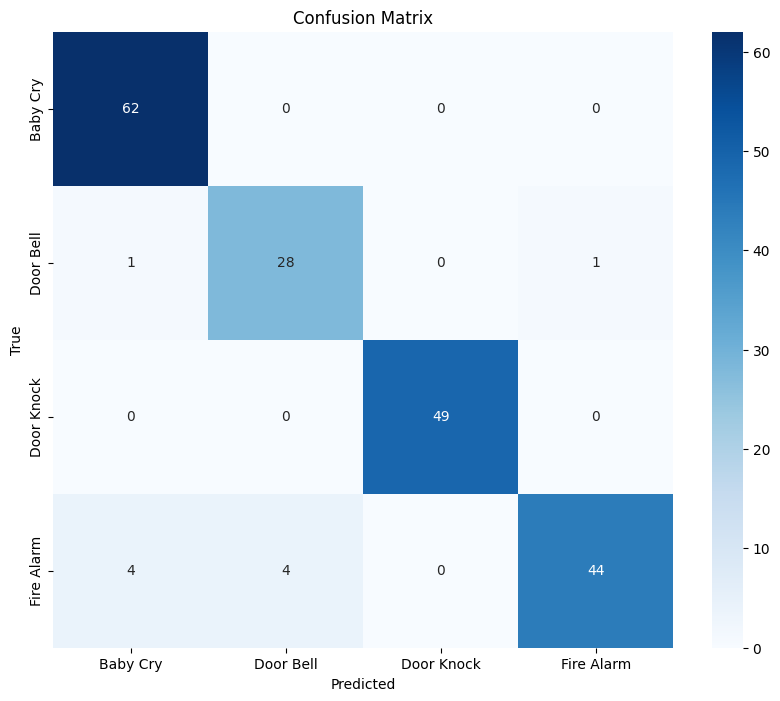

              precision    recall  f1-score   support

    Baby Cry       0.93      1.00      0.96        62
   Door Bell       0.88      0.93      0.90        30
  Door Knock       1.00      1.00      1.00        49
  Fire Alarm       0.98      0.85      0.91        52

    accuracy                           0.95       193
   macro avg       0.94      0.94      0.94       193
weighted avg       0.95      0.95      0.95       193

Class: Baby Cry
Precision: 0.9254
Recall: 1.0000
F1 Score: 0.9612
Support: 62.0
--------------------
Class: Door Bell
Precision: 0.8750
Recall: 0.9333
F1 Score: 0.9032
Support: 30.0
--------------------
Class: Door Knock
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Support: 49.0
--------------------
Class: Fire Alarm
Precision: 0.9778
Recall: 0.8462
F1 Score: 0.9072
Support: 52.0
--------------------


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model_with_confusion_matrix(model, dataloader, class_names):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Print individual metrics for each class
    for class_name, metrics in cr.items():
        if class_name in class_names:
            print(f"Class: {class_name}")
            print(f"Precision: {metrics['precision']:.4f}")
            print(f"Recall: {metrics['recall']:.4f}")
            print(f"F1 Score: {metrics['f1-score']:.4f}")
            print(f"Support: {metrics['support']}")
            print("-" * 20)

# Evaluate the model on the test data with confusion matrix and detailed metrics
evaluate_model_with_confusion_matrix(model, test_loader, class_names)


In [15]:
from PIL import Image
# Function to predict the class for a single input image
def predict_image(model, image_path, class_names):
    model.eval()  # Set model to evaluation mode
    image = Image.open(image_path).convert('RGB')
    image = test_transforms(image).unsqueeze(0)  # Apply transformations and add batch dimension

    with torch.no_grad():
        image = image.to(device)
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        predicted_class = class_names[preds.item()]

    return predicted_class

# Assuming class_names is a list of class names corresponding to the classes in your dataset
class_names = test_dataset.classes

# Predict the class for an input image
image_path = "C:\\Users\\PC\\Desktop\\lisnen_data\\Melspectrograms\\Melspectrograms\\Door_Bell\\doorbell_audio-2.png"
predicted_class = predict_image(model, image_path, class_names)
print(f'Predicted Class: {predicted_class}')

Predicted Class: Door_Bell_Melspectrorams
